<a href="https://colab.research.google.com/github/MorningStarTM/skull-stripping/blob/main/Skull_Stripping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from tqdm import tqdm
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Conv2DTranspose, MaxPool2D, ReLU, Input, BatchNormalization, Concatenate, Lambda, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

In [43]:
#Global variable
BATCH_SIZE = 16
W,H = 256, 256
CHANNEL = 3
lr = 1e-6

In [26]:
def iou(y_true, y_pred):
  def f(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    x = (intersection + 1e-15) / (union + 1e-15)
    x = x.astype(np.float32)
    return x
  return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
  y_true = tf.keras.layers.Flatten()(y_true)
  y_pred = tf.keras.layers.Flatten()(y_pred)
  intersection = tf.reduce_sum(y_true * y_pred)
  return (2. * intersection  + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
  return 1.0 - dice_coef(y_true, y_pred)

# U-NET

In [52]:
def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPool2D((2,2))(x)
  return x, p

def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

def build_unet(input_shape):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 32)
  s2, p2 = encoder_block(p1, 64)
  s3, p3 = encoder_block(p2, 128)
  s4, p4 = encoder_block(p3, 256)
  s5, p5 = encoder_block(p4, 512)

  b1 = conv_block(p5, 1024)

  d1 = decoder_block(b1, s5, 512)
  d2 = decoder_block(d1, s4, 256)
  d3 = decoder_block(d2, s3, 128)
  d4 = decoder_block(d3, s2, 64)
  d5 = decoder_block(d4, s1, 32)
  outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d5)

  model = Model(inputs, outputs, name='U-Net')
  return model

In [53]:
inputs_shape = (256,256,3)
model = build_unet(inputs_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_80 (Conv2D)             (None, 256, 256, 32  896         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_24 (BatchN  (None, 256, 256, 32  128        ['conv2d_80[0][0]']              
 ormalization)                  )                                                             

In [54]:
metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

# Preparing Dataset

In [9]:
model_path = os.path.join("/content/drive/MyDrive/CNN_Models","unet_for_skull_stripping.h5")
csv_path = os.path.join("/content/drive/MyDrive/DataSet/random","unet_for_skull_stripping.csv")
path = "/content/drive/MyDrive/DataSet/skull_strpping"
split = 0.1

In [10]:
train_path = "/content/drive/MyDrive/DataSet/skull_strpping/train"
test_path = "/content/drive/MyDrive/DataSet/skull_strpping/test"

In [11]:
#load dataset
def load_data(path, split=0.1):
  images = sorted(glob(os.path.join(path, "image_1/*")))
  masks = sorted(glob(os.path.join(path, "mask_1/*")))
  
  return images, masks

In [12]:
#process image function
def read_img(path):
  img = cv2.imread(path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (256, 256))
  img = img / 255
  img = img.astype(np.float32)
  return img

#process mask function
def read_mask(path):
  mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask, (256, 256))
  mask = mask / 255
  mask = np.expand_dims(mask, axis=-1)
  mask = mask.astype(np.float32)
  return mask

In [13]:
def preprocess(x, y):
  def f(x, y):
    x = x.decode()
    y = y.decode()
    
    x = read_img(x)
    y = read_mask(y)
    return x, y

  image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
  image.set_shape([256, 256, 3])
  mask.set_shape([256, 256, 1])

  return image, mask

In [14]:
def tf_dataset(x, y, batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.shuffle(buffer_size=1000)
  dataset = dataset.map(preprocess)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(2)
  return dataset

In [15]:
train_images, train_masks = load_data(train_path)
test_images, test_masks = load_data(test_path)
print(f'image: {len(train_images)} - Masks: {len(train_masks)}')
print(f'image: {len(test_images)} - Masks: {len(test_masks)}')

image: 712 - Masks: 712
image: 72 - Masks: 72


In [16]:
train_dataset = tf_dataset(train_images, train_masks, batch=BATCH_SIZE)
test_dataset = tf_dataset(test_images, test_masks, batch=BATCH_SIZE)

In [55]:
Callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True), 
    CSVLogger(csv_path),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

In [71]:
model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset, 
    callbacks=Callbacks
    )

Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 0.2840 - dice_coef: 0.7158 - iou: 0.5578 - recall_5: 0.9570 - precision_5: 0.7967
Epoch 1: val_loss did not improve from 0.33478
45/45 [==============================] - 16s 346ms/step - loss: 0.2840 - dice_coef: 0.7158 - iou: 0.5578 - recall_5: 0.9570 - precision_5: 0.7967 - val_loss: 0.3379 - val_dice_coef: 0.6641 - val_iou: 0.4974 - val_recall_5: 0.8987 - val_precision_5: 0.7519 - lr: 1.0000e-06
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 0.2814 - dice_coef: 0.7185 - iou: 0.5609 - recall_5: 0.9574 - precision_5: 0.8031
Epoch 2: val_loss did not improve from 0.33478
45/45 [==============================] - 15s 323ms/step - loss: 0.2814 - dice_coef: 0.7185 - iou: 0.5609 - recall_5: 0.9574 - precision_5: 0.8031 - val_loss: 0.3349 - val_dice_coef: 0.6654 - val_iou: 0.4988 - val_recall_5: 0.9145 - val_precision_5: 0.7409 - lr: 1.0000e-06
Epoch 3/50
45/45 [==============================] - ETA: 0s 

In [ ]:
unet = load_model("/content/drive/MyDrive/CNN_Models/unet_for_skull_stripping.h5")

In [72]:
for img, msk in tqdm(zip(test_images, test_masks), total=len(test_images)):
  image_name = img.split("/")[-1]

  ori_x = cv2.imread(img, cv2.IMREAD_COLOR)
  ori_x = cv2.resize(ori_x, (W,H))
  x = ori_x / 255.0
  x = x.astype(np.float32)
  x = np.expand_dims(x, axis=0)

  ori_y = cv2.imread(msk, cv2.IMREAD_GRAYSCALE)
  ori_y = cv2.resize(ori_y, (W,H))
  ori_y = np.expand_dims(ori_y, axis=-1)
  
  y_pred = model.predict(x)[0] > 0.5  
  y_pred = y_pred.astype(np.int32)
  y_pred = y_pred.reshape(256, 256, 1)

  print(ori_x.shape, ori_y.shape, y_pred.shape)
  save_image_path = f"/content/predicted/{image_name}"

  sep_line = np.ones((H, 10, 3)) * 255
  cat_image = np.concatenate([ori_y, y_pred*255], axis=1)
  cv2.imwrite(save_image_path, cat_image)

  0%|          | 0/72 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/72 [00:00<00:05, 12.85it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 19ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 4/72 [00:00<00:05, 12.43it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 6/72 [00:00<00:05, 12.19it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step


 11%|█         | 8/72 [00:00<00:05, 12.20it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 19ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 10/72 [00:00<00:04, 12.53it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 19ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 12/72 [00:00<00:04, 12.68it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 14/72 [00:01<00:04, 12.50it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 25ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 16/72 [00:01<00:04, 12.30it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 18/72 [00:01<00:04, 12.23it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 20/72 [00:01<00:04, 12.19it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step


 31%|███       | 22/72 [00:01<00:04, 12.29it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 24/72 [00:01<00:03, 12.10it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 19ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 26/72 [00:02<00:03, 12.47it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 28/72 [00:02<00:03, 12.36it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 30/72 [00:02<00:03, 12.37it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 18ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 32/72 [00:02<00:03, 12.39it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 34/72 [00:02<00:03, 11.99it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 36/72 [00:02<00:02, 12.08it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 38/72 [00:03<00:02, 12.25it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 22ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 40/72 [00:03<00:02, 11.96it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 18ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 42/72 [00:03<00:02, 12.18it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 44/72 [00:03<00:02, 12.23it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 46/72 [00:03<00:02, 12.54it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 48/72 [00:03<00:01, 12.15it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 19ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 50/72 [00:04<00:01, 12.37it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 19ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 52/72 [00:04<00:01, 12.11it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 54/72 [00:04<00:01, 12.34it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 22ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 56/72 [00:04<00:01, 12.28it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 18ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 18ms/step


 81%|████████  | 58/72 [00:04<00:01, 11.98it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 18ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 60/72 [00:04<00:00, 12.12it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 22ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 62/72 [00:05<00:00, 12.17it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 19ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 64/72 [00:05<00:00, 12.26it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 19ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 66/72 [00:05<00:00, 12.14it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 19ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 68/72 [00:05<00:00, 12.11it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 70/72 [00:05<00:00, 12.03it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 19ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 22ms/step


100%|██████████| 72/72 [00:05<00:00, 12.22it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)


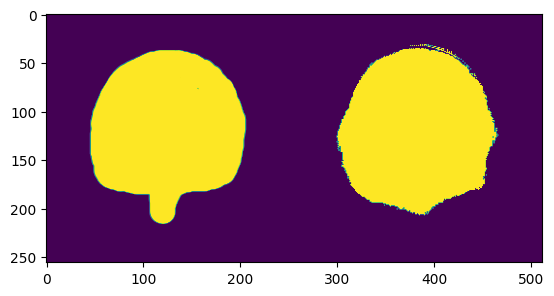

In [79]:
i = "/content/predicted/2300.png"
i = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
plt.imshow(i)